In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [3]:
set_plot_sizes(12,14,16)

In [4]:
import feather
df_raw = feather.read_dataframe('tmp/bulldozers_raw')

In [5]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [6]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [7]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [8]:
set_rf_samples(50000)

In [9]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11112037755049176, 0.20052224378579317, 0.9764941688551635, 0.6466996932496849, 0.910839731955605]


In [10]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

Wall time: 2.17 s


(10.986237030381682, 0.24916467202585726)

In [11]:
y_valid[0]

10.778956289890028

In [13]:
preds.shape

(40, 12000)

# Confidence based on tree variance

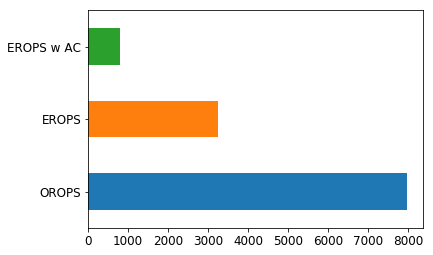

In [47]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [48]:
x.Enclosure.value_counts()

OROPS         7972
EROPS         3243
EROPS w AC     784
Name: Enclosure, dtype: int64

In [49]:
flds = ['Enclosure' , 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure' , as_index = False).mean();enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.996246,9.907967,0.271014
1,EROPS w AC,10.235214,10.148372,0.260203
2,OROPS,9.972491,9.915519,0.264436


In [50]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.996246,9.907967,0.271014
1,EROPS w AC,10.235214,10.148372,0.260203
2,OROPS,9.972491,9.915519,0.264436


In [51]:
x = enc_summ[~np.isnan(enc_summ.SalePrice)]

In [52]:
x

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.996246,9.907967,0.271014
1,EROPS w AC,10.235214,10.148372,0.260203
2,OROPS,9.972491,9.915519,0.264436


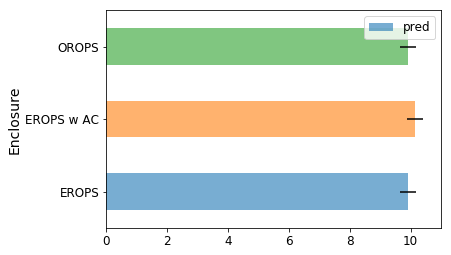

In [53]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11)) # using {xerr='pred_std'} for error bar

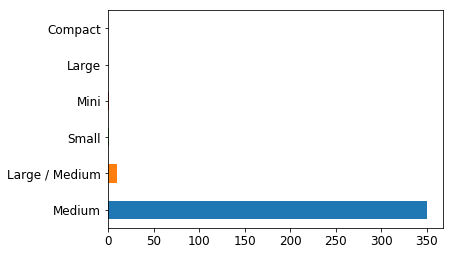

In [55]:
raw_valid.ProductSize.value_counts().plot('barh')

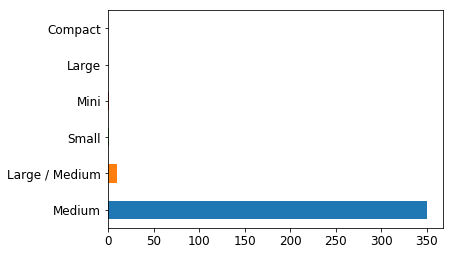

In [56]:
raw_valid.ProductSize.value_counts().plot.barh();

In [59]:
(enc_summ.pred_std / enc_summ.pred).sort_values(ascending = False)

0    0.027353
2    0.026669
1    0.025640
dtype: float64

 so Erops has less confidence 

# feature importance 

In [65]:
fi = rf_feat_importance(m,df_trn);fi[:10]

,cols,imp
5,YearMade,0.176830
37,Coupler_System,0.087822
16,ProductGroup,0.085535
14,fiProductClassDesc,0.074033
19,Enclosure,0.065113
17,ProductGroupDesc,0.052109
13,ProductSize,0.051630
10,fiSecondaryDesc,0.033407
63,saleElapsed,0.031695
39,Hydraulics_Flow,0.031195


In [66]:
fi = rf_feat_importance(m,df_raw);fi[:10]

,cols,imp
5,auctioneerID,0.176830
37,Coupler,0.087822
16,state,0.085535
14,ProductSize,0.074033
19,Drive_System,0.065113
17,ProductGroup,0.052109
13,fiModelDescriptor,0.051630
10,fiBaseModel,0.033407
63,saleIs_year_start,0.031695
39,Grouser_Tracks,0.031195
